## Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

# 2 layers Full batch

In [4]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10
batch_size = 64


class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False):
        super(NeuralNet2layer, self).__init__()
        self.initialize=initialize
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.batchnorm = batchnorm


        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        if self.initialize=='NTK':

            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)




    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        else:

            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        return out
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [9]:
outlist=[]
for iiiddd in [0]:
    index=0
    learning_rate = 0.5
    torch.manual_seed(0)
    batchnorm=False
    if index==1 or index==2:
        batchnorm=True
    device = torch.device('cuda')
    model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=batchnorm).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    aclist=[]

    
    for runsteps in range(1000*20):
        if (index==0 or index==2) and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.2,ln=1,oflag=1,mode=1)
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if lo<0.01:
            break
    outlist.append([losslist,aclist])

Adjusting Layer 1, Kernel Nodes: 645, Adptive Nodes155


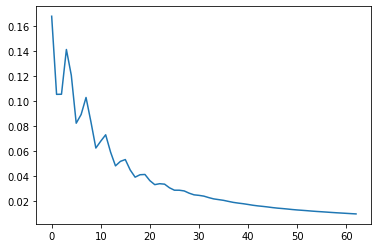

In [10]:
plt.plot(outlist[0][0],'-',label='Original')

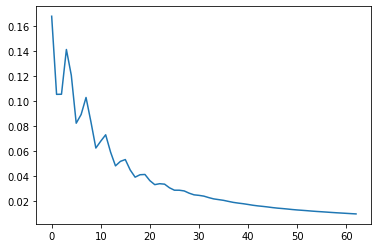

In [8]:
#plt.plot(outlist[0][0],'-',label='Original')
plt.plot(outlist[1][0],'-',label='Modification')

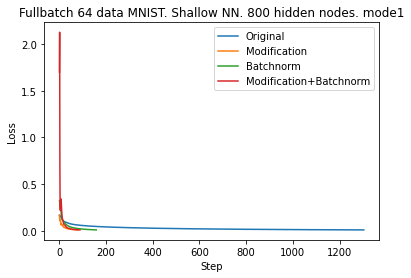

In [ ]:
# plot loss
plt.plot(outlist[0][0],'-',label='Original')
plt.plot(outlist[1][0],'-',label='Modification')
plt.plot(outlist[2][0],'-',label='Batchnorm')
plt.plot(outlist[3][0],'-',label='Modification+Batchnorm')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('Fullbatch 64 data MNIST. Shallow NN. 800 hidden nodes. mode1')
plt.savefig('/content/drive/My Drive/LCNN/plot/BN1.pdf')

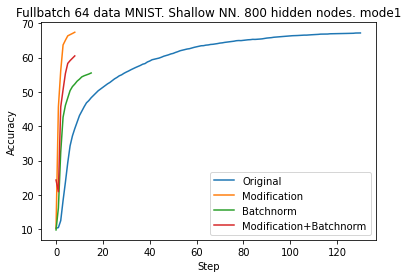

In [ ]:
# plot accuracy
plt.plot(outlist[0][1],'-',label='Original')
plt.plot(outlist[1][1],'-',label='Modification')
plt.plot(outlist[2][1],'-',label='Batchnorm')
plt.plot(outlist[3][1],'-',label='Modification+Batchnorm')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('Fullbatch 64 data MNIST. Shallow NN. 800 hidden nodes. mode1')
plt.savefig('/content/drive/My Drive/LCNN/plot/BN2.pdf')

# 4 layers Minibatch

In [12]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64



class NeuralNet4layer(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,initialize='NTK',batchnorm=False):
        super(NeuralNet4layer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)
        self.input_size=input_size
        self.hidden_size1=hidden_size1
        self.hidden_size2=hidden_size2
        self.hidden_size3=hidden_size3
        self.batchnorm=batchnorm
        self.initialize=initialize

        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
            self.bn2 = nn.BatchNorm1d(num_features=hidden_size3)
        
        if self.initialize=='NTK':
            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)
            self.fc3.weight.detach().uniform_(-1, 1)
            self.fc3.bias.detach().uniform_(-1, 1)
            self.fc4.weight.detach().uniform_(-1,1)

    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = self.fc3(out)
                out = self.bn2(out)
                out = self.relu2(out)
                out = self.fc4(out)
            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
                out = self.fc3(out)
                out = out/np.sqrt(self.hidden_size2)
                out = self.bn2(out)
                out = self.relu2(out)
                out = self.fc4(out)
                out = out/np.sqrt(self.hidden_size3)
        else:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)
                out = self.fc3(out)
                out = self.relu2(out)
                out = self.fc4(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
                out = self.fc3(out)
                out = out/np.sqrt(self.hidden_size2)
                out = self.relu2(out)
                out = self.fc4(out)
                out = out/np.sqrt(self.hidden_size3)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [16]:
outlist=[]
for index in [0,1,2]:
# Index= -1, Original
#      = 0 Our modification
#      = 1 Bathnorm
#.     = 2 Our modification+Our modification
    learning_rate = 0.5
    torch.manual_seed(0)
    batchnorm=False
    if index==1 or index==2:
        batchnorm=True
    device = torch.device('cuda')
    print(batchnorm)
    model = NeuralNet4layer(input_size,hidden_size1,hidden_size2,hidden_size3,initialize='NTK', batchnorm=batchnorm).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    aclist=[]
    steploss=[]
    num_epochs=10000
    

    
    for epoch in range(num_epochs):
        loss_epoch=0
        count=0
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)

            if (index==0 or index==2) and (i==0 and epoch==0):
                adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.1,ln=1,oflag=1,mode=1)

            if (index==0 or index==2) and (i==5 and epoch==0):
                model.fc2.register_forward_hook(get_activation('fc2'))
                output = model(images)
                adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.1,ln=3,oflag=1,mode=1) 
            if (count<10) and epoch==0:
                print(count,loss.item())
            count=count+1
            steploss.append(loss.item())
            loss_epoch=loss_epoch+loss.item()       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        if epoch %10 == 0:
            ac=accuracy(model,valloader)
            aclist.append(ac)
            print ('{} Epoch [{}/{}], Loss: {:.4f}' .format(index, epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.01:
            break
    outlist.append([losslist,steploss,aclist])

False
Adjusting Layer 1, Kernel Nodes: 683, Adptive Nodes117
0 0.11053480207920074
1 0.10915471613407135
2 0.11083952337503433
3 0.1041114553809166
4 0.1043705865740776
Adjusting Layer 3, Kernel Nodes: 88, Adptive Nodes12
5 0.10233499854803085
6 0.09788771718740463
7 0.09518736600875854
8 0.0918603241443634
9 0.09027808904647827
Accuracy: 90.7700 %
0 Epoch [1/10000], Loss: 0.0326
Accuracy: 96.1000 %
0 Epoch [11/10000], Loss: 0.0100
True
0 0.33394655585289
1 0.30726009607315063
2 0.3191819190979004
3 0.2862716615200043
4 0.25710543990135193
5 0.2509571611881256
6 0.19978943467140198
7 0.18183183670043945
8 0.16808928549289703
9 0.168454110622406
Accuracy: 88.2100 %
1 Epoch [1/10000], Loss: 0.0455
Accuracy: 94.5900 %
1 Epoch [11/10000], Loss: 0.0149
Accuracy: 95.6600 %
1 Epoch [21/10000], Loss: 0.0117
Accuracy: 96.1500 %
1 Epoch [31/10000], Loss: 0.0101
True
Adjusting Layer 1, Kernel Nodes: 683, Adptive Nodes117
0 0.33394655585289
1 0.3068941831588745
2 0.30861711502075195
3 0.2408245801

Text(0.5, 1.0, 'MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')

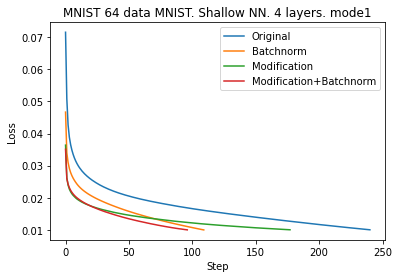

In [ ]:
# plot loss
plt.plot(outlist[0][0],'-',label='Original')

plt.plot(outlist[2][0],'-',label='Batchnorm')
plt.plot(outlist[1][0],'-',label='Modification')
plt.plot(outlist[3][0],'-',label='Modification+Batchnorm')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')
#plt.savefig('/content/drive/My Drive/LCNN/plot/BN1.pdf')

Text(0.5, 1.0, 'MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')

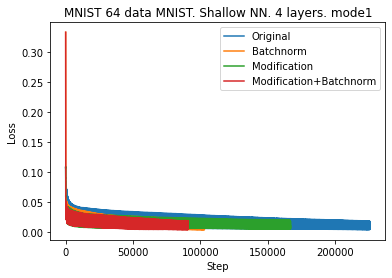

In [ ]:
# plot Step loss
plt.plot(outlist[0][1],'-',label='Original')
plt.plot(outlist[2][1],'-',label='Batchnorm')
plt.plot(outlist[1][1],'-',label='Modification')
plt.plot(outlist[3][1],'-',label='Modification+Batchnorm')


plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')
#plt.savefig('/content/drive/My Drive/LCNN/plot/BN1.pdf')

Text(0.5, 1.0, 'MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')

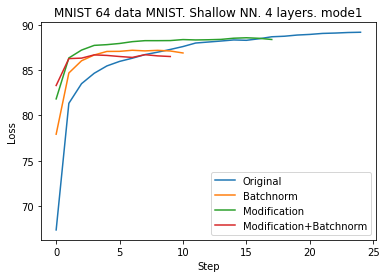

In [ ]:
# plot accuracy
plt.plot(outlist[0][2],'-',label='Original')

plt.plot(outlist[2][2],'-',label='Batchnorm')
plt.plot(outlist[1][2],'-',label='Modification')
plt.plot(outlist[3][2],'-',label='Modification+Batchnorm')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')
#plt.savefig('/content/drive/My Drive/LCNN/plot/BN1.pdf')